In [1]:
!date

import warnings
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter(action="ignore", category=FutureWarning)

lun jun  8 05:30:54 CEST 2020


In [2]:
df_all = pd.read_csv("13-14.txt", sep="\t")
team_names = df_all["Home \ Away "].str.strip().copy(deep=True).values
team_abbrs = df_all.columns.str.strip().copy(deep=True).values[1:]
df_all = df_all.melt(id_vars=["Home \ Away "])
df_all.columns = ["home_team", "away_team", "result"]
df_all = df_all.apply(lambda x: x.str.strip(), axis="index")
df_all = df_all.replace(
    {
        "away_team": {abbr: team for abbr, team in zip(team_abbrs, team_names)},
        "result": {"—": np.nan}
    }
).dropna(subset=["result"]).reset_index(drop=True)
df_aux = df_all.result.str.split("–", expand=True)
df_aux.columns = ["home_goals", "away_goals"]
df_final = pd.concat((df_all[["home_team", "away_team"]], df_aux), axis="columns")
df_final.to_csv("premier_13-14.csv", index=False)

In [3]:
df = pd.read_csv("premier_13-14.csv")
num_teams = df.home_team.nunique()

In [4]:
with pm.Model() as m_general:
    # constant data
    home_team = pm.intX(pm.Data("home_team", pd.factorize(df.home_team, sort=True)[0]))
    away_team = pm.intX(pm.Data("away_team", pd.factorize(df.away_team, sort=True)[0]))
    
    # global model parameters
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_goals = pm.Poisson('home_goals', mu=home_theta, observed=df.home_goals)
    away_goals = pm.Poisson('away_goals', mu=away_theta, observed=df.away_goals)

In [5]:
dims = {
    "home_goals": ["match"],
    "away_goals": ["match"],
    "home_team": ["match"],
    "away_team": ["match"],
    "atts": ["team"],
    "atts_star": ["team"],
    "defs": ["team"],
    "defs_star": ["team"],
}
coords = {"team": pd.factorize(df.home_team, sort=True)[1]}
with m_general:
    trace = pm.sample(random_seed=1375)
    idata_general = az.from_pymc3(trace, coords=coords, dims=dims)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1629.96draws/s]


In [6]:
idata_general

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [7]:
with pm.Model() as m_match:
    # constant data
    home_team = pm.intX(pm.Data("home_team", pd.factorize(df.home_team, sort=True)[0]))
    away_team = pm.intX(pm.Data("away_team", pd.factorize(df.away_team, sort=True)[0]))
    
    # global model parameters
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # alternative likelihood of observed data
    def double_poisson(h, a):
        return (
            pm.Poisson.dist(mu=home_theta).logp(h) + 
            pm.Poisson.dist(mu=away_theta).logp(a)
        )
    
    matches = pm.DensityDist('matches', double_poisson, observed={'h': df.home_goals, 'a': df.away_goals})

In [8]:
dims = {
    "goals": ["match"],
    "home_team": ["match"],
    "away_team": ["match"],
    "atts": ["team"],
    "atts_star": ["team"],
    "defs": ["team"],
    "defs_star": ["team"],
}
coords = {"team": pd.factorize(df.home_team, sort=True)[1]}
with m_match:
    trace = pm.sample(random_seed=1375, tune=1500)
    idata_match = az.from_pymc3(trace, coords=coords, dims=dims)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1817.65draws/s]


In [9]:
idata_match

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> constant_data

In [10]:
az.loo(idata_match)

Computed from 2000 by 380 log-likelihood matrix

         Estimate       SE
elpd_loo -1120.14    17.61
p_loo       30.91        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [11]:
idata_general.log_likelihood["match_lik"] = (
    idata_general.log_likelihood.home_goals + idata_general.log_likelihood.away_goals
)
az.loo(idata_general, var_name="match_lik")

Computed from 2000 by 380 log-likelihood matrix

         Estimate       SE
elpd_loo -1120.35    17.56
p_loo       31.02        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [12]:
df_home = df[["home_team", "away_team", "home_goals"]].rename(columns={"home_goals": "goals"})
df_home["visitor"] = 0
df_away = df[["home_team", "away_team", "away_goals"]].rename(columns={"away_goals": "goals"})
df_away["visitor"] = 1
df_goals = pd.concat((df_home, df_away), axis="index")
df_goals

,home_team,away_team,goals,visitor
0,Aston Villa,Arsenal,1,0
1,Cardiff City,Arsenal,0,0
2,Chelsea,Arsenal,6,0
3,Crystal Palace,Arsenal,0,0
4,Everton,Arsenal,3,0
...,...,...,...,...
375,Stoke City,West Ham United,1,1
376,Sunderland,West Ham United,2,1
377,Swansea City,West Ham United,0,1
378,Tottenham Hotspur,West Ham United,3,1


In [13]:
with pm.Model() as m_goals:
    # constant data
    home_team = pm.intX(pm.Data("home_team", pd.factorize(df_goals.home_team, sort=True)[0]))
    away_team = pm.intX(pm.Data("away_team", pd.factorize(df_goals.away_team, sort=True)[0]))
    is_visitor = pm.intX(pm.Data("is_visitor", df_goals.visitor))
    
    # global model parameters
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_aux = tt.stack([home, 0])
    pars_aux = tt.stack([defs, atts])
    theta = tt.exp(
        intercept + home_aux[is_visitor] + pars_aux[(is_visitor, away_team)] + pars_aux[(1-is_visitor, home_team)]
    )

    # alternative likelihood of observed data
    goals = pm.Poisson('goals', mu=theta, observed=df_goals.goals.values)

In [14]:
dims = {
    "goals": ["idx"],
    "home_team": ["idx"],
    "away_team": ["idx"],
    "atts": ["team"],
    "atts_star": ["team"],
    "defs": ["team"],
    "defs_star": ["team"],
}
coords = {"team": pd.factorize(df_goals.home_team, sort=True)[1]}
with m_goals:
    trace = pm.sample(random_seed=1375, tune=1500)
    idata_goals = az.from_pymc3(trace, coords=coords, dims=dims)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:07<00:00, 1013.20draws/s]


In [15]:
idata_goals

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [16]:
az.loo(idata_goals)

Computed from 2000 by 760 log-likelihood matrix

         Estimate       SE
elpd_loo -1120.20    18.49
p_loo       30.92        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [17]:
import xarray as xr
idata_general.log_likelihood["goals_lik"] = xr.concat(
    (idata_general.log_likelihood.home_goals, idata_general.log_likelihood.away_goals), 
    "match"
).rename({"match": "observation"})
az.loo(idata_general, var_name="goals_lik")

Computed from 2000 by 760 log-likelihood matrix

         Estimate       SE
elpd_loo -1120.33    18.46
p_loo       30.97        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/arviz/plots/densityplot.py:215: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (42) in plot_density, generating only 40 plots
  UserWarning,


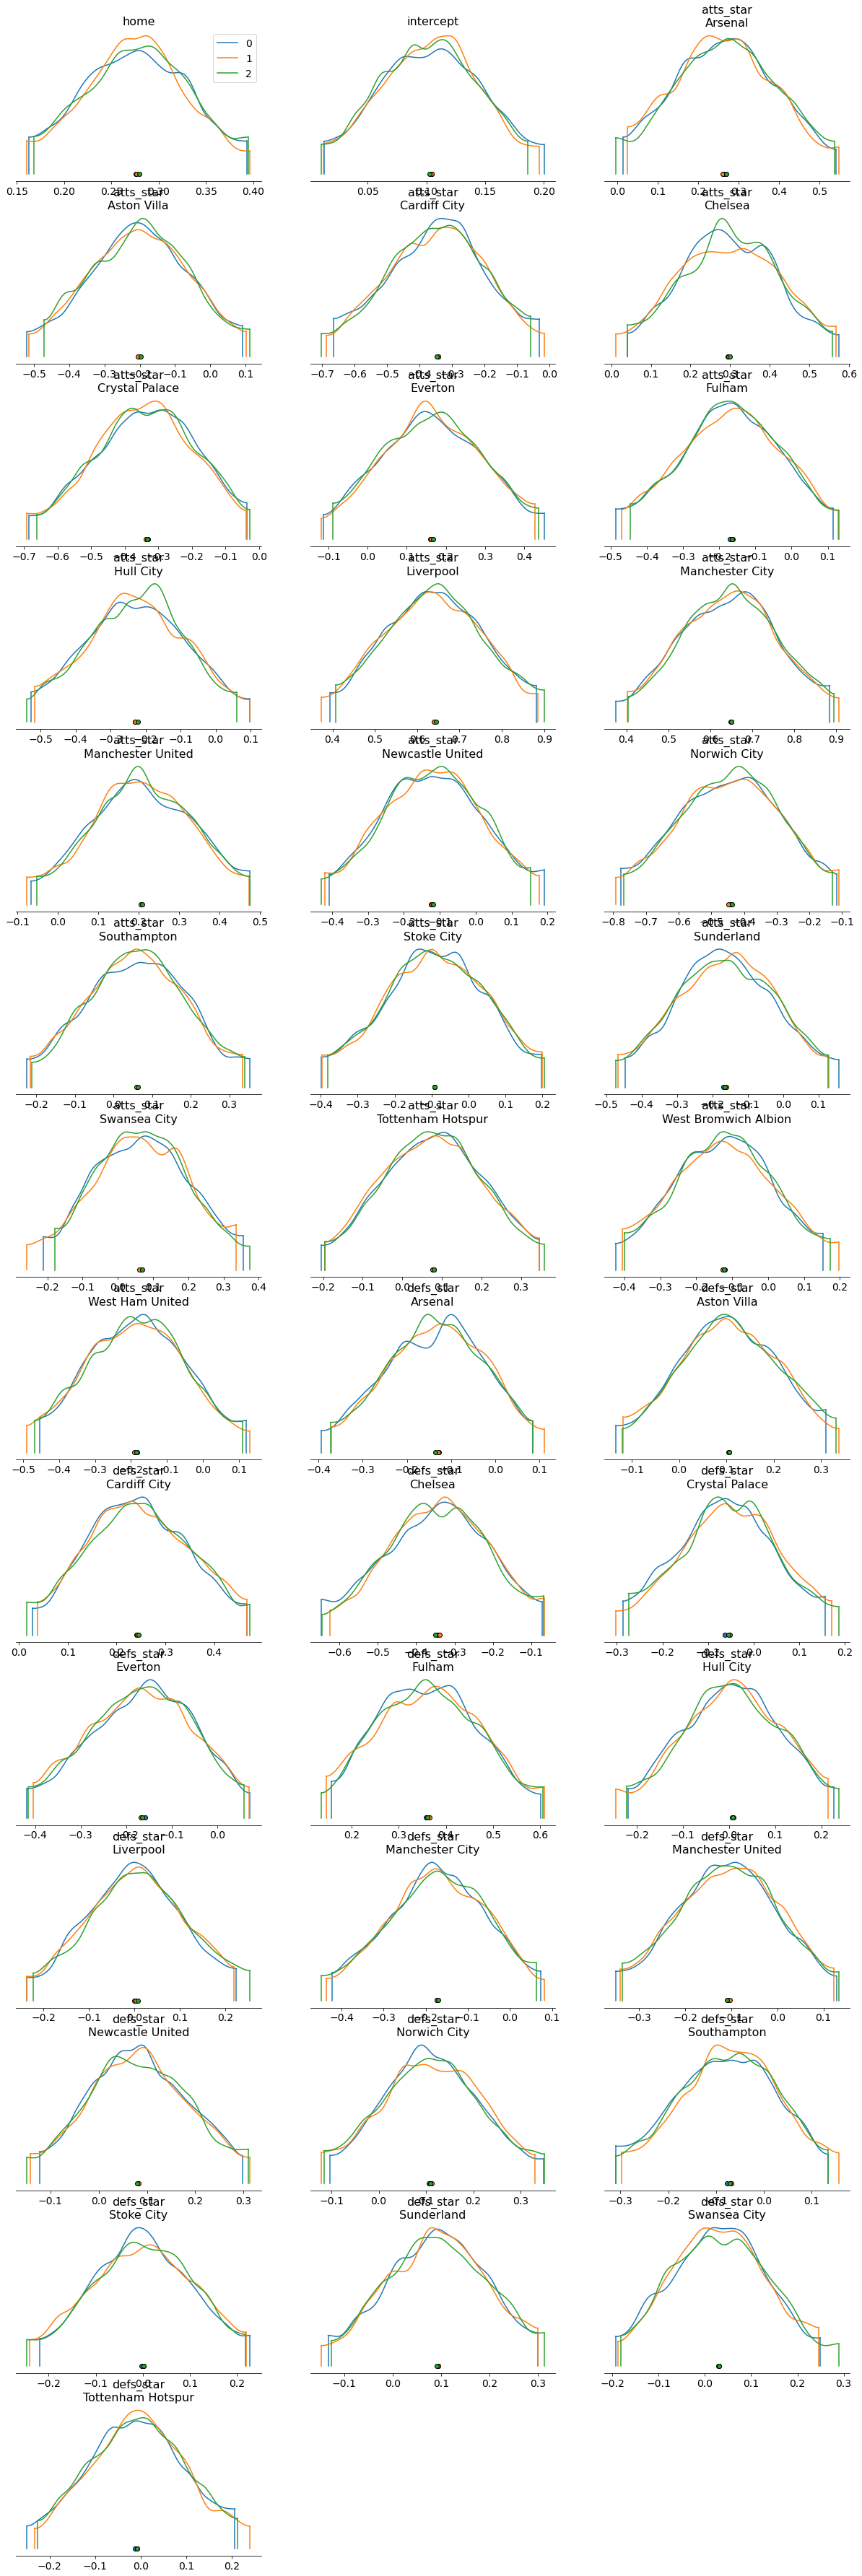

In [18]:
az.plot_density(
    (idata_general, idata_goals, idata_match), 
    var_names=["home", "intercept", "atts_star", "defs_star"],
);